In [180]:
#importacion de librerias
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [181]:
#Conexion a la BD y creacion del cursor para ejecutar las consultas
con = sqlite3.connect("bright.sqlite")

cur = con.cursor()

## Creamos un dataframe para cada tabla

In [182]:
#Dataframe de eventos

events_df = pd.read_sql_query("select * from event", con)
#events_df = pd.read_csv("events.csv")
events_df.head()

,event_id,user_id,lead_id,created_at,event_type
0,662958237495922433,9086291099700738296,662958237495922433,2015-01-09T05:46:27Z,lead.created
1,5936803624202314553,9086291099700738296,5936803624202314553,2015-01-10T22:49:25Z,lead.created
2,2741481737418820220,9086291099700738296,2741481737418820220,2015-01-11T02:21:34Z,lead.created
3,931548343476776527,9086291099700738296,931548343476776527,2015-01-11T04:20:47Z,lead.created
4,6268873583045809549,9086291099700738296,6268873583045809549,2015-01-11T04:51:39Z,lead.created


In [183]:
lead_df = pd.read_sql_query("select * from lead", con)
#lead_df = pd.read_csv("lead.csv")
lead_df.head()

,lead_id,created_at
0,662958237495922433,2015-01-09T05:46:27Z
1,5936803624202314553,2015-01-10T22:49:25Z
2,2741481737418820220,2015-01-11T02:21:34Z
3,931548343476776527,2015-01-11T04:20:47Z
4,6268873583045809549,2015-01-11T04:51:39Z


In [ ]:
attribute_df = pd.read_sql_query("select * from attribute", con)
#attribute_df = pd.read_csv("attribute.csv")
attribute_df.head()

,lead_id,name,value
0,4034644098856872731,ecUserId,6827679502985037031
1,2522396480838382595,ecUserId,4163434151428399388
2,4771679237096686581,ecUserId,1771557218257997535
3,2856139873214022965,ecUserId,5107531245397791315
4,417414713521421577,ecUserId,3862948945971877120


ruta = 'C:\\Users\\joseg\\Downloads\\bright\\'
file = "attribute.csv"
attribute_df.to_csv(ruta + file, index=False)

In [185]:
#Simplificamos fechas 
events_df['created_at']=pd.to_datetime(events_df['created_at']).dt.strftime('%Y/%m/%d')
#events_df.head()

lead_df['created_at']=pd.to_datetime(lead_df['created_at']).dt.strftime('%Y/%m/%d')
lead_df.head()

,lead_id,created_at
0,662958237495922433,2015/01/09
1,5936803624202314553,2015/01/10
2,2741481737418820220,2015/01/11
3,931548343476776527,2015/01/11
4,6268873583045809549,2015/01/11


In [186]:
#Usamos las columnas necesarias para los calculos de 
lead_ifo = events_df[['lead_id', 'created_at', 'event_type']]
lead_ifo.head()

,lead_id,created_at,event_type
0,662958237495922433,2015/01/09,lead.created
1,5936803624202314553,2015/01/10,lead.created
2,2741481737418820220,2015/01/11,lead.created
3,931548343476776527,2015/01/11,lead.created
4,6268873583045809549,2015/01/11,lead.created


## Análisis de tasas de conversion

In [83]:
#Calculo de valores
total_clientes = lead_ifo['event_type'].value_counts()['lead.created']
total_visitas = lead_ifo['event_type'].value_counts()['doc.salesVisitReport.uploaded']
total_aprov = lead_ifo['event_type'].value_counts()['doc.subscriptionContract.approved']

print(f"Numero de clientes dados de alta: {total_clientes} \nNumero de clientes que resivieron una visita de ventas: {total_visitas}  \nNumero de clientes aprovados: {total_aprov} \nEl porcentaje de clientes que recibieron una visita es de: {total_visitas/total_clientes * 100} \nEl porcentaje de aprovación de los clientes que reciben una visita es de: {total_aprov/total_visitas *100}")

Numero de clientes dados de alta: 176229 
Numero de clientes que resivieron una visita de ventas: 26041  
Numero de clientes aprovados: 4165 
El porcentaje de clientes que recibieron una visita es de: 14.776796100528289 
El porcentaje de aprovación de los clientes que reciben una visita es de: 15.994009446641835


In [84]:
print(f"Entonces tenemos que: \nLead -> APP = {total_aprov/total_clientes * 100}% \nLead -> SV = {total_visitas/total_clientes * 100}% \nSV -> APP = {total_aprov/total_visitas *100}%")

Entonces tenemos que: 
Lead -> APP = 2.363402164229497% 
Lead -> SV = 14.776796100528289% 
SV -> APP = 15.994009446641835


In [199]:
df_visit = lead_ifo.loc[lead_ifo['event_type'].isin(['lead.created', 'doc.salesVisitReport.uploaded'])]
df_visit = df_visit.sort_values(by=['lead_id', 'created_at'])
df_visit['created_at'] = pd.to_datetime(df_visit['created_at'], format='%Y/%m/%d')
df_visit

,lead_id,created_at,event_type
132461,29168939509383,2020-12-09,lead.created
76300,78173867883681,2019-08-11,lead.created
151974,145450590088648,2021-06-05,lead.created
24659,206871463078275,2018-02-07,lead.created
281381,206871463078275,2018-02-13,doc.salesVisitReport.uploaded
...,...,...,...
133952,9223088399209857622,2021-01-03,lead.created
141142,9223268460736605695,2021-03-23,lead.created
1037340,9223268460736605695,2021-03-25,doc.salesVisitReport.uploaded
4779,9223308794280945893,2016-09-08,lead.created


In [200]:
# Obtener los cliente que han sido visitados
df_lead_visit = df_visit[df_visit.duplicated(subset='lead_id', keep=False)]['lead_id']

filtered_df = df_visit[df_visit['lead_id'].isin(df_lead_visit)]

# Mostrar el DataFrame filtrado
filtered_df

,lead_id,created_at,event_type
24659,206871463078275,2018-02-07,lead.created
281381,206871463078275,2018-02-13,doc.salesVisitReport.uploaded
5852,479319542561749,2016-11-16,lead.created
195499,479319542561749,2017-02-07,doc.salesVisitReport.uploaded
8341,600953040659714,2017-06-09,lead.created
...,...,...,...
247215,9222626109309112746,2017-10-24,doc.salesVisitReport.uploaded
92542,9222640695009194716,2020-01-05,lead.created
753066,9222640695009194716,2020-04-08,doc.salesVisitReport.uploaded
141142,9223268460736605695,2021-03-23,lead.created


In [201]:
filtered_df['visit_speed'] = filtered_df.groupby('lead_id')['created_at'].diff().dt.days
filtered_df

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_9920/1022283709.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lead_id,created_at,event_type,visit_speed
24659,206871463078275,2018-02-07,lead.created,NaN
281381,206871463078275,2018-02-13,doc.salesVisitReport.uploaded,6.0
5852,479319542561749,2016-11-16,lead.created,NaN
195499,479319542561749,2017-02-07,doc.salesVisitReport.uploaded,83.0
8341,600953040659714,2017-06-09,lead.created,NaN
...,...,...,...,...
247215,9222626109309112746,2017-10-24,doc.salesVisitReport.uploaded,7.0
92542,9222640695009194716,2020-01-05,lead.created,NaN
753066,9222640695009194716,2020-04-08,doc.salesVisitReport.uploaded,94.0
141142,9223268460736605695,2021-03-23,lead.created,NaN


In [214]:
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])
filtered_df = filtered_df.query("created_at >= '2020-01-01' & created_at <= '2020-12-31'")
filtered_df['semestre'] = pd.PeriodIndex(filtered_df['created_at'], freq='Q')



C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_9920/2642619520.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_9920/2642619520.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [218]:
periodos = filtered_df.groupby('semestre')['visit_speed'].mean()
print(f"{periodos}")


semestre
2020Q1    27.192501
2020Q2    28.574541
2020Q3    27.953349
2020Q4    73.892674
Freq: Q-DEC, Name: visit_speed, dtype: float64


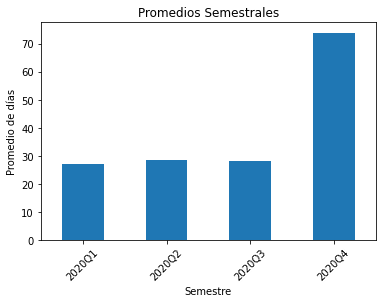

In [216]:
periodos.plot(kind='bar')
plt.xlabel('Semestre')
plt.ylabel('Promedio de días')
plt.title('Promedios Semestrales')
plt.xticks(rotation=45)
plt.show()


## Conclusión:
#### Entonces tenemos que los valores de conversión son: 
#### Lead -> APP = 2.363402164229497% 
#### Lead -> SV = 14.776796100528289% 
#### SV -> APP = 15.994009446641835

# ---------------------------------------------------------

#### También podemos observar que durante los primero 3 trimestres de 2021 hay un promedio de un mes antes de la visita de ventas, es hasta el último trimestre que los tiempos se disparan hasta 70 días 

## Análisis de tiempos de instalación

In [85]:
#Creamos un df con la informacion de la instalacion (datos desde la aprovacion hasta la instalacion)
install_info = lead_ifo.loc[lead_ifo['event_type'].isin(['doc.subscriptionContract.approved', 'doc.installationComplete.uploaded'])]
install_info

,lead_id,created_at,event_type
247699,7269108836429264416,2017/10/25,doc.installationComplete.uploaded
247700,7269108836429264416,2017/10/25,doc.installationComplete.uploaded
247702,7269108836429264416,2017/10/25,doc.installationComplete.uploaded
247729,7269108836429264416,2017/10/25,doc.installationComplete.uploaded
247730,4056675780933243260,2017/10/25,doc.installationComplete.uploaded
...,...,...,...
1519841,1815574803749072256,2021/11/19,doc.subscriptionContract.approved
1519903,2444264167966191626,2021/11/20,doc.subscriptionContract.approved
1519993,4349944640334975053,2021/11/22,doc.subscriptionContract.approved
1520217,6065284994562979706,2021/11/23,doc.subscriptionContract.approved


In [86]:
#Limpiamos, ordenamos y formateamos nuestro df
df = install_info.sort_values(by=['lead_id', 'created_at'])
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y/%m/%d')
df

,lead_id,created_at,event_type
1315631,600953040659714,2017-07-06,doc.subscriptionContract.approved
248816,600953040659714,2017-10-25,doc.installationComplete.uploaded
1349810,5983374979821661,2018-06-30,doc.subscriptionContract.approved
330517,5983374979821661,2018-07-19,doc.installationComplete.uploaded
1445648,6425731670857076,2020-10-01,doc.subscriptionContract.approved
...,...,...,...
1384777,9215931655637972512,2019-07-31,doc.subscriptionContract.approved
529054,9215931655637972512,2019-08-26,doc.installationComplete.uploaded
1299309,9221856919341974555,2016-07-08,doc.subscriptionContract.approved
1472735,9223268460736605695,2021-04-14,doc.subscriptionContract.approved


In [87]:
#Finalmente calculamos el tiempo desde que se aprobo hasta que se instalo (installation_speed)
df['installation_speed'] = df.groupby('lead_id')['created_at'].diff().dt.days
df

,lead_id,created_at,event_type,installation_speed
1315631,600953040659714,2017-07-06,doc.subscriptionContract.approved,NaN
248816,600953040659714,2017-10-25,doc.installationComplete.uploaded,111.0
1349810,5983374979821661,2018-06-30,doc.subscriptionContract.approved,NaN
330517,5983374979821661,2018-07-19,doc.installationComplete.uploaded,19.0
1445648,6425731670857076,2020-10-01,doc.subscriptionContract.approved,NaN
...,...,...,...,...
1384777,9215931655637972512,2019-07-31,doc.subscriptionContract.approved,NaN
529054,9215931655637972512,2019-08-26,doc.installationComplete.uploaded,26.0
1299309,9221856919341974555,2016-07-08,doc.subscriptionContract.approved,NaN
1472735,9223268460736605695,2021-04-14,doc.subscriptionContract.approved,NaN


In [150]:
#Creamos un df con la información de instalacion limpia
df_install_speed = df.query("event_type == 'doc.installationComplete.uploaded'")
df_install_speed = df_install_speed.query("installation_speed > 0")
df_install_speed

,lead_id,created_at,event_type,installation_speed
248613,8476861005387807898,2017-10-25,doc.installationComplete.uploaded,208.0
248231,8477776547713684838,2017-10-25,doc.installationComplete.uploaded,694.0
248046,2878412093209138963,2017-10-25,doc.installationComplete.uploaded,342.0
247776,3044689925278934954,2017-10-25,doc.installationComplete.uploaded,393.0
248018,6447365324981946908,2017-10-25,doc.installationComplete.uploaded,460.0
...,...,...,...,...
1294326,2090736158285505276,2021-11-22,doc.installationComplete.uploaded,34.0
1294341,2834455967499435798,2021-11-22,doc.installationComplete.uploaded,25.0
1295930,7319618385632409254,2021-11-23,doc.installationComplete.uploaded,70.0
1295944,2147696339789437861,2021-11-23,doc.installationComplete.uploaded,27.0


In [151]:
#Se calcula el promedio de tiempo de instalacion para todo el df
promedio = df_install_speed['installation_speed'].mean()
print(f"El tiempo de instalacion promedio es de: {promedio} días")

El tiempo de instalacion promedio es de: 155.916766610698 días


In [156]:
#Creamos un gráfico para analizar la relación entre fechas y días de instalación
import plotly.express as px
# Crear el gráfico interactivo utilizando Plotly
fig = px.scatter(df_install_speed, x='created_at', y='installation_speed', color='installation_speed',
                 labels={'created_at': 'Fecha', 'installation_speed': 'Días de instalación', 'lead_id': 'ID'},
                 title='Relación entre las fechas y los días de instalación')

# Configurar la apariencia del gráfico
fig.update_traces(marker=dict(size=10))

# Mostrar el gráfico interactivo
fig.show()

In [217]:
#Se ve una anomalia en octubre de 2017 la analizamos de la siguiente manera
#Se puede observar que en un periodo de practicamente dos días se completaron más de 800 instalaciones 
#NOTE: esto no significa que la instalación duró 2 días, cada instalación tuvo su periodo de duración pero culminaron dentro de estos dos días 

oct17 = df_install_speed.query("created_at >= '2017-10-01' & created_at <= '2017-10-30'")
oct17


,lead_id,created_at,event_type,installation_speed
248613,8476861005387807898,2017-10-25,doc.installationComplete.uploaded,208.0
248231,8477776547713684838,2017-10-25,doc.installationComplete.uploaded,694.0
248046,2878412093209138963,2017-10-25,doc.installationComplete.uploaded,342.0
247776,3044689925278934954,2017-10-25,doc.installationComplete.uploaded,393.0
248018,6447365324981946908,2017-10-25,doc.installationComplete.uploaded,460.0
...,...,...,...,...
249113,1321327382790064590,2017-10-26,doc.installationComplete.uploaded,1.0
249062,4019740506356180451,2017-10-26,doc.installationComplete.uploaded,27.0
249168,7769108528013229199,2017-10-26,doc.installationComplete.uploaded,49.0
249268,1569909593760656170,2017-10-26,doc.installationComplete.uploaded,84.0


In [173]:
#Calculamos el promedio de octubre del 2017
oct17_prom = oct17['installation_speed'].mean()
print(f"El promedio de instalación de octubre del 2017 fue de: {oct17_prom}")

El promedio de instalación de octubre del 2017 fue de: 426.9212410501193


In [152]:
#seleccionamos un periodo de fechas (primer semestre de 2020 y primer semestre de 2021)
#Para calcular los promedios de instalacion en ellos
Periodo_1 = df_install_speed.query("created_at >= '2020-01-01' & created_at <= '2020-06-30'")
Periodo_2 = df_install_speed.query("created_at >= '2021-01-01' & created_at <= '2021-06-30'")
Periodo1_prom = Periodo_1['installation_speed'].mean()
Periodo2_prom = Periodo_2['installation_speed'].mean()

print(f"El promedio de instalación del primer semestre del 2020 fue de: {Periodo1_prom} días \nEl promedio de instalación del primer semestre del 2021 fue de: {Periodo2_prom} días")

El promedio de instalación del primer semestre del 2020 fue de: 105.12903225806451 días 
El promedio de instalación del primer semestre de 2021 fue de: 99.61608775137111 días


In [178]:
#Creamos un gráfico para analizar la relación entre fechas y días de instalación dentro de un periodo
import plotly.express as px
# Crear el gráfico interactivo utilizando Plotly
fig = px.scatter(Periodo_1, x='created_at', y='installation_speed', color='installation_speed',
                 labels={'created_at': 'Fecha', 'installation_speed': 'Días de instalación', 'lead_id': 'ID'},
                 title='Relación entre las fechas y los días de instalación')

# Configurar la apariencia del gráfico
fig.update_traces(marker=dict(size=10))

# Mostrar el gráfico interactivo
fig.show()

In [179]:
#Creamos un gráfico para analizar la relación entre fechas y días de instalación dentro de un periodo
import plotly.express as px
# Crear el gráfico interactivo utilizando Plotly
fig = px.scatter(Periodo_2, x='created_at', y='installation_speed', color='installation_speed',
                 labels={'created_at': 'Fecha', 'installation_speed': 'Días de instalación', 'lead_id': 'ID'},
                 title='Relación entre las fechas y los días de instalación')

# Configurar la apariencia del gráfico
fig.update_traces(marker=dict(size=10))

# Mostrar el gráfico interactivo
fig.show()

## Conclusión 

#### pudimos calcular el promedio de días de instalación que son: 155 días asi como detectar que durante el mes de octubre del año 2017 se concluyeron al rededor de 800 instalaciones con un promedio de: 426 días, esto lo convierte en el mes donde se concluyeron las instalaciones con la mayor duración 